In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import nilearn
from nilearn.connectome import ConnectivityMeasure
# import matplotlib as mpl
# mpl.use('Agg')

In [66]:
sites = ['CALTECH', 'CMUA', 'KKI', 'LEUVEN1', 'LEUVEN2', 'MAXMUNA', 'MAXMUNB', \
         'MAXMUNC', 'MAXMUND', 'NYU', 'OHSU', 'OLIN', 'PITT', 'SBL', 'SDSU', \
         'STANFORD', 'TRINITY', 'UCLA1', 'UCLA2', 'UM1', 'UM2', 'USM', 'YALE']

In [67]:
abide = nilearn.datasets.fetch_abide_pcp(derivatives=['rois_aal'], SITE_ID=sites, pipeline='cpac')

/Users/anish.simhal/anaconda3/envs/neuro/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [68]:
foo = abide.phenotypic['DX_GROUP']

In [69]:
len(foo)

553

In [55]:
ages = abide.phenotypic['AGE_AT_SCAN']

In [56]:
age_groups = [np.sum(np.logical_and(ages >= 5, ages <= 10)), np.sum(np.logical_and(ages >= 10, ages <= 15)), np.sum(np.logical_and(ages >= 15, ages <= 20)),
              np.sum(np.logical_and(ages >= 20, ages <= 30)), np.sum(np.logical_and(ages >= 30, ages <= 65))]

In [57]:
age_groups

[88, 203, 124, 107, 43]

In [58]:
len(ages)

553

/Users/anish.simhal/anaconda3/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

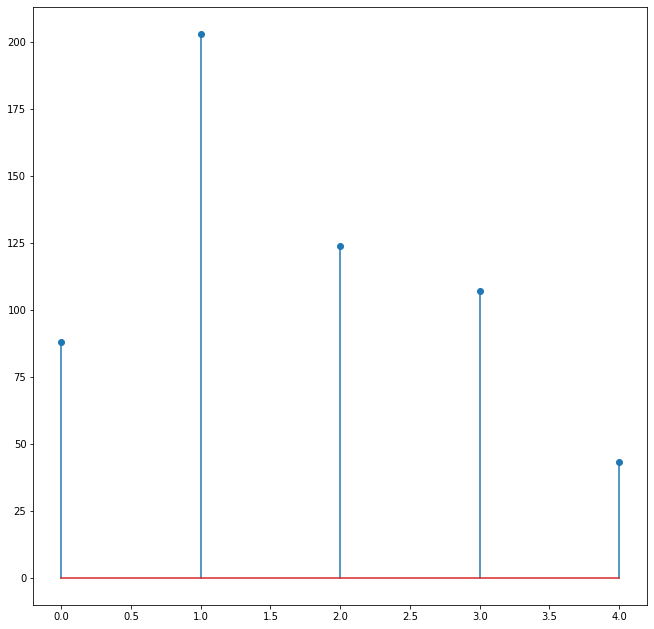

In [8]:
plt.figure(figsize=(11,11))
plt.stem(age_groups)

In [9]:
conn_est = ConnectivityMeasure(kind='partial correlation')
conn_matrices = conn_est.fit_transform(abide.rois_aal)
conn_matrices.shape

(553, 116, 116)

In [28]:
import bct

In [29]:
np.percentile(conn_matrices[0,...], 80)

0.0556746310533895

In [30]:
num_subs = conn_matrices.shape[0]
num_roi = conn_matrices.shape[1]

In [31]:
ct_bi = np.zeros((conn_matrices.shape))
for i in range(ct_bi.shape[0]):
    ct_bi[i,...][conn_matrices[i,...] >= np.percentile(conn_matrices[i,...], 80)] = 1

In [32]:
clust_coef = np.zeros((num_subs,num_roi))

for i in range(num_subs):
    clust_coef[i,:] = bct.clustering_coef_bu(ct_bi[i,...])

In [33]:
trans = np.zeros((num_subs,1))

for i in range(num_subs):
    trans[i] = bct.transitivity_bu(ct_bi[i,...])

In [34]:
char_path = np.zeros((num_subs,num_roi + 4))

for i in range(num_subs):
    char_path_res = bct.charpath(bct.distance_bin(ct_bi[i,...]))
    char_path[i,:num_roi] = char_path_res[2]
    char_path[i,num_roi] = char_path_res[0]
    char_path[i,num_roi + 1] = char_path_res[1]
    char_path[i,num_roi + 2] = char_path_res[3]
    char_path[i,num_roi + 3] = char_path_res[4]

In [35]:
eff = np.zeros((num_subs,num_roi + 1))

for i in range(num_subs):
    eff[i,:num_roi] = bct.efficiency_bin(ct_bi[i,...], local=True)
    eff[i,num_roi] = bct.efficiency_bin(ct_bi[i,...])

In [36]:
btw_cen = np.zeros((num_subs,num_roi))

for i in range(num_subs):
    btw_cen[i,:] = bct.betweenness_bin(ct_bi[i,...])

In [37]:
mod_z_score = np.zeros((num_subs,num_roi))
part_coef = np.zeros((num_subs,num_roi))

for i in range(num_subs):
    comms, _ = bct.community_louvain(ct_bi[i,...])
    
    mod_z_score[i,:] = bct.module_degree_zscore(ct_bi[i,...], comms)
    part_coef[i,:] = bct.participation_coef(ct_bi[i,...], comms)

In [38]:
X = np.hstack((clust_coef, trans, char_path, eff, btw_cen, mod_z_score, part_coef))

In [39]:
X.shape

(553, 702)

In [40]:
import sklearn
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [41]:
y = abide.phenotypic['DX_GROUP']

In [42]:
shuffle = np.hstack((X, y.reshape(-1,1)))
np.random.shuffle(shuffle)
X_shuffle = shuffle[:,:-1]
y_shuffle = shuffle[:,-1]

In [43]:
print(X_shuffle.shape, y_shuffle.shape)

(553, 702) (553,)


In [44]:
nanm = np.isnan(X_shuffle)
len(np.where(np.sum(nanm, axis=0) > 0)[0])

118

In [45]:
X_final = np.delete(X_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)

In [46]:
nanm = np.isinf(X_final)
len(np.where(np.sum(nanm, axis=0) > 0)[0])

1

In [47]:
X_finalfinal = np.delete(X_final, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)

In [48]:
X_finalfinal.shape

(553, 583)

In [49]:
svm = sklearn.svm.SVC(kernel='linear')

sfs1 = SFS(svm, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X_finalfinal, y_shuffle)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [50]:
sfs1.k_feature_idx_

()

In [51]:
X_top10 = X_finalfinal[:,sfs1.k_feature_idx_]
X_top10.shape

(553, 0)

In [52]:
all_iter_results = []
for i in range(100):
    all_iter_results.append([])
    kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
    for train_index, test_index in kf.split(X_top10):
        X_train, X_test = X_top10[train_index], X_top10[test_index]
        y_train, y_test = y_shuffle[train_index], y_shuffle[test_index]

        clf = sklearn.svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        sensitivity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=2)
        specificity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=1)
        all_iter_results[i].append([sensitivity, specificity])

ValueError: Found array with 0 feature(s) (shape=(497, 0)) while a minimum of 1 is required.

In [ ]:
clf_results = np.array(all_iter_results)

clf_iter_avg = []
for i in range(clf_results.shape[0]):
    clf_iter = clf_results[i,:,:]
    clf_iter_avg.append(np.mean(clf_iter, axis=0))
    
clf_df0 = pd.DataFrame(data=clf_iter_avg, columns=['Sensitivity', 'Specificity'])

In [ ]:
clf_df0.mean()

In [ ]:
X_a1 = X[np.logical_and(ages >= 5, ages < 10),:]
X_a2 = X[np.logical_and(ages >= 10, ages < 15),:]
X_a3 = X[np.logical_and(ages >= 15, ages < 20),:]
X_a4 = X[np.logical_and(ages >= 20, ages < 30),:]
X_a5 = X[np.logical_and(ages >= 30, ages < 65),:]

y_a1 = y[np.logical_and(ages >= 5, ages < 10)]
y_a2 = y[np.logical_and(ages >= 10, ages < 15)]
y_a3 = y[np.logical_and(ages >= 15, ages < 20)]
y_a4 = y[np.logical_and(ages >= 20, ages < 30)]
y_a5 = y[np.logical_and(ages >= 30, ages < 65)]

In [ ]:
data = [(X_a1, y_a1), (X_a2, y_a2), (X_a3, y_a3), (X_a4, y_a4), (X_a5, y_a5)]

In [ ]:
shuffle = np.hstack((X, y.reshape(-1,1)))
np.random.shuffle(shuffle)
X_shuffle = shuffle[:,:-1]
y_shuffle = shuffle[:,-1]

nanm = np.isnan(X_shuffle)
X_final = np.delete(X_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)
infm = np.isinf(X_final)
X_finalfinal = np.delete(X_final, np.where(np.sum(infm, axis=0) > 0)[0], axis=1)

In [ ]:
for group in data:
    xc = group[0]
    yc = group[1]
    shuffle = np.hstack((xc, yc.reshape(-1,1)))
    np.random.shuffle(shuffle)
    xc_shuffle = shuffle[:,:-1]
    yc_shuffle = shuffle[:,-1]
    
    nanm = np.isnan(xc_shuffle)
    xc_final = np.delete(xc_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)
    infm = np.isinf(xc_final)
    xc_finalfinal = np.delete(xc_final, np.where(np.sum(infm, axis=0) > 0)[0], axis=1)
    
    sfs1 = sfs1.fit(xc_finalfinal, yc_shuffle)
    xc_top10 = xc_finalfinal[:,sfs1.k_feature_idx_]
    
    all_iter_results = []
    for i in range(100):
        all_iter_results.append([])
        kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
        for train_index, test_index in kf.split(xc_top10):
            X_train, X_test = xc_top10[train_index], xc_top10[test_index]
            y_train, y_test = yc_shuffle[train_index], yc_shuffle[test_index]

            clf = sklearn.svm.SVC(kernel='linear')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            sensitivity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=2)
            specificity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=1)
            all_iter_results[i].append([sensitivity, specificity])
            
    clf_results = np.array(all_iter_results)

    clf_iter_avg = []
    for i in range(clf_results.shape[0]):
        clf_iter = clf_results[i,:,:]
        clf_iter_avg.append(np.mean(clf_iter, axis=0))

    clf_df0 = pd.DataFrame(data=clf_iter_avg, columns=['Sensitivity', 'Specificity'])
    
    print(clf_df0.mean())

In [ ]:
np.array(clf_df0.mean()).shape

In [ ]:
kinds = ['correlation', 'partial correlation', 'tangent', 'covariance', 'precision']

In [ ]:
results_all = {}
for kind in kinds:
    svm_results = np.zeros((len(kinds), 2))
    
    conn_est = ConnectivityMeasure(kind=kind)
    conn_matrices = conn_est.fit_transform(abide.rois_aal)
    
    ct_bi = np.zeros((conn_matrices.shape))
    for i in range(ct_bi.shape[0]):
        ct_bi[i,...][conn_matrices[i,...] >= np.percentile(conn_matrices[i,...], 80)] = 1
        
    clust_coef = np.zeros((num_subs,num_roi))
    for i in range(num_subs):
        clust_coef[i,:] = bct.clustering_coef_bu(ct_bi[i,...])
        
    trans = np.zeros((num_subs,1))
    for i in range(num_subs):
        trans[i] = bct.transitivity_bu(ct_bi[i,...])
        
    char_path = np.zeros((num_subs,num_roi + 4))
    for i in range(num_subs):
        char_path_res = bct.charpath(bct.distance_bin(ct_bi[i,...]))
        char_path[i,:num_roi] = char_path_res[2]
        char_path[i,num_roi] = char_path_res[0]
        char_path[i,num_roi + 1] = char_path_res[1]
        char_path[i,num_roi + 2] = char_path_res[3]
        char_path[i,num_roi + 3] = char_path_res[4]
    
    eff = np.zeros((num_subs,num_roi + 1))
    for i in range(num_subs):
        eff[i,:num_roi] = bct.efficiency_bin(ct_bi[i,...], local=True)
        eff[i,num_roi] = bct.efficiency_bin(ct_bi[i,...])
        
    btw_cen = np.zeros((num_subs,num_roi))
    for i in range(num_subs):
        btw_cen[i,:] = bct.betweenness_bin(ct_bi[i,...])
        
    mod_z_score = np.zeros((num_subs,num_roi))
    part_coef = np.zeros((num_subs,num_roi))
    for i in range(num_subs):
        comms, _ = bct.community_louvain(ct_bi[i,...])

        mod_z_score[i,:] = bct.module_degree_zscore(ct_bi[i,...], comms)
        part_coef[i,:] = bct.participation_coef(ct_bi[i,...], comms)
        
    X = np.hstack((clust_coef, trans, char_path, eff, btw_cen, mod_z_score, part_coef))
    X_a1 = X[np.logical_and(ages >= 5, ages < 10),:]
    X_a2 = X[np.logical_and(ages >= 10, ages < 15),:]
    X_a3 = X[np.logical_and(ages >= 15, ages < 20),:]
    X_a4 = X[np.logical_and(ages >= 20, ages < 30),:]
    X_a5 = X[np.logical_and(ages >= 30, ages < 65),:]

    y_a1 = y[np.logical_and(ages >= 5, ages < 10)]
    y_a2 = y[np.logical_and(ages >= 10, ages < 15)]
    y_a3 = y[np.logical_and(ages >= 15, ages < 20)]
    y_a4 = y[np.logical_and(ages >= 20, ages < 30)]
    y_a5 = y[np.logical_and(ages >= 30, ages < 65)]
    
    data = [(X_a1, y_a1), (X_a2, y_a2), (X_a3, y_a3), (X_a4, y_a4), (X_a5, y_a5)]
    for g, group in enumerate(data):
        xc = group[0]
        yc = group[1]
        shuffle = np.hstack((xc, yc.reshape(-1,1)))
        np.random.shuffle(shuffle)
        xc_shuffle = shuffle[:,:-1]
        yc_shuffle = shuffle[:,-1]

        nanm = np.isnan(xc_shuffle)
        xc_final = np.delete(xc_shuffle, np.where(np.sum(nanm, axis=0) > 0)[0], axis=1)
        infm = np.isinf(xc_final)
        xc_finalfinal = np.delete(xc_final, np.where(np.sum(infm, axis=0) > 0)[0], axis=1)

        sfs1 = sfs1.fit(xc_finalfinal, yc_shuffle)
        xc_top10 = xc_finalfinal[:,sfs1.k_feature_idx_]

        all_iter_results = []
        for i in range(100):
            all_iter_results.append([])
            kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
            for train_index, test_index in kf.split(xc_top10):
                X_train, X_test = xc_top10[train_index], xc_top10[test_index]
                y_train, y_test = yc_shuffle[train_index], yc_shuffle[test_index]

                clf = sklearn.svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                sensitivity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=2)
                specificity = sklearn.metrics.recall_score(y_test, y_pred, pos_label=1)
                all_iter_results[i].append([sensitivity, specificity])

        clf_results = np.array(all_iter_results)

        clf_iter_avg = []
        for i in range(clf_results.shape[0]):
            clf_iter = clf_results[i,:,:]
            clf_iter_avg.append(np.mean(clf_iter, axis=0))

        clf_df0 = pd.DataFrame(data=clf_iter_avg, columns=['Sensitivity', 'Specificity'])
        svm_results[g,:] = np.array(clf_df0.mean()).reshape(-1,1)
        
    results_all[kind] = svm_results